In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, QuantileTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.ensemble import IsolationForest
import xgboost as xgb
import joblib
from scipy import stats

In [2]:
pip install seaborn 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import seaborn as sns
sns.set()  # This sets seaborn style globally


In [4]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [5]:
plt.style.use('seaborn-v0_8') 

In [6]:
df = pd.read_csv("co2 _capture_data_new.csv")

In [7]:
df = df.dropna(axis=1, how='all').drop_duplicates()

In [8]:
z_scores = stats.zscore(df.select_dtypes(include=[np.number]))
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]

In [9]:
X = df[['T', 'pCO2', 'm', 'C']]
y = df['loading']

In [10]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X)
poly_feature_names = poly.get_feature_names_out(['T', 'pCO2', 'm', 'C'])
X = pd.DataFrame(X_poly, columns=poly_feature_names)

In [11]:
target_transformer = QuantileTransformer(output_distribution='normal')
y_transformed = target_transformer.fit_transform(y.values.reshape(-1, 1)).flatten()

C:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (234). n_quantiles is set to n_samples.
  warnings.warn(


In [12]:
xgb_for_rfe = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
selector = RFE(estimator=xgb_for_rfe, n_features_to_select=8, step=1)
selector.fit(X, y_transformed)

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, device=None,
                           early_stopping_rounds=None, enable_categorical=False,
                           eval_metric=None, feature_types=None,
                           feature_weights=None, gamma=None, grow_policy=None,
                           importance_type=None, interaction_constraints=None,
                           learning_rate=None, max_bin=None,
                           max_cat_threshold=None, max_cat_to_onehot=None,
                           max_delta_step=None, max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, multi_strategy=None,
                           n_estimators=None, n_jobs=None,
                           num_parallel_tree=None, ...),
    n_features_to_select=8)

In [13]:
selected_features = X.columns[selector.support_]
X_selected = X[selected_features]

In [14]:
print(f"Selected features: {list(selected_features)}")

Selected features: ['T', 'pCO2', 'm', 'C', 'T pCO2', 'T C', 'pCO2 m', 'm C']


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_transformed, test_size=0.2, random_state=42
)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(X_train_scaled)
X_train_clean = X_train_scaled[outliers == 1]
y_train_clean = y_train[outliers == 1]

In [18]:
print(f"Final training samples: {X_train_clean.shape[0]}")

Final training samples: 177


In [98]:
param_dist = {
    'n_estimators': [100,300, 500, 700,900 ],
    'max_depth': [ 7, 9, 11,13,15],
    'learning_rate': [0.001,0.005, 0.01,0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4,0.5,0.6],
    'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0, 0.1,0.2, 0.5, 1, 5],
    'reg_lambda': [0, 0.1, 0.5, 1, 5],
    'max_delta_step': [0, 1, 2, 3]
}

In [99]:
tscv = TimeSeriesSplit(n_splits=5)

In [100]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [101]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [102]:
print("Starting hyperparameter optimization...")
random_search.fit(X_train_clean, y_train_clean)
print("Optimization complete!")

Starting hyperparameter optimization...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Optimization complete!


In [103]:
best_xgb = random_search.best_estimator_
print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best R² score (CV): {random_search.best_score_:.4f}")


Best parameters: {'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 15, 'max_delta_step': 2, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best R² score (CV): 0.4252


In [104]:
y_train_pred = target_transformer.inverse_transform(
    best_xgb.predict(X_train_clean).reshape(-1, 1)
).flatten()
y_test_pred = target_transformer.inverse_transform(
    best_xgb.predict(X_test_scaled).reshape(-1, 1)
).flatten()

In [105]:
train_r2 = r2_score(target_transformer.inverse_transform(y_train_clean.reshape(-1, 1)), y_train_pred)
test_r2 = r2_score(target_transformer.inverse_transform(y_test.reshape(-1, 1)), y_test_pred)

In [106]:
print(f"\nTraining R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")


Training R²: 0.7708
Test R²: 0.6522


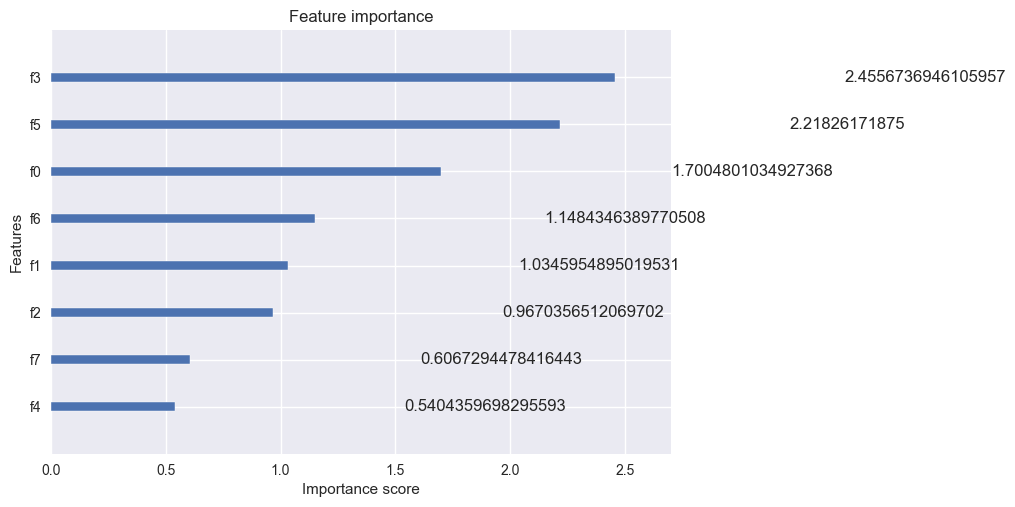

In [107]:
xgb.plot_importance(best_xgb, importance_type='gain', max_num_features=15)
plt.show()

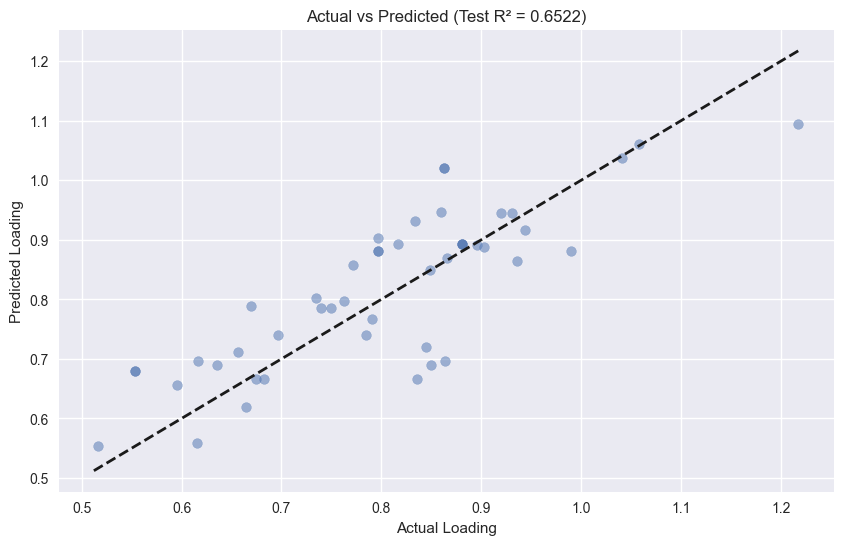

In [108]:
plt.figure(figsize=(10, 6))
plt.scatter(target_transformer.inverse_transform(y_test.reshape(-1, 1)), y_test_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Loading')
plt.ylabel('Predicted Loading')
plt.title(f'Actual vs Predicted (Test R² = {test_r2:.4f})')
plt.grid(True)
plt.show()

In [109]:
model_components = {
    'model': best_xgb,
    'scaler': scaler,
    'feature_selector': selector,
    'target_transformer': target_transformer,
    'poly_transformer': poly,
    'selected_features': selected_features
}

In [110]:
joblib.dump(model_components, 'optimized_co2_model.pkl')
print("Model components saved successfully!")

Model components saved successfully!


In [111]:
df = pd.read_csv("Book2.csv")

In [112]:
df

,T,pCO2,m,C
0,293.15,20.27,0.25,1
1,293.15,20.27,0.25,2
2,293.15,20.27,0.25,3
3,298.15,20.27,0.25,1
4,303.15,20.27,0.25,1
5,303.15,20.27,0.25,2
6,303.15,20.27,0.25,3
7,308.15,20.27,0.25,1
8,313.15,20.27,0.05,1
9,313.15,20.27,0.10,1


In [113]:
def predict_and_save(file_path):
    components = joblib.load('optimized_co2_model.pkl')
    new_data = pd.read_csv("Book2.csv")

    X_new_poly = components['poly_transformer'].transform(new_data)
    X_new_poly = pd.DataFrame(X_new_poly,
                          columns=components['poly_transformer'].get_feature_names_out())
    X_new_selected = X_new_poly[components['selected_features']]
    X_new_scaled = components['scaler'].transform(X_new_selected)
    preds_transformed = components['model'].predict(X_new_scaled)
    predictions = components['target_transformer'].inverse_transform(
        preds_transformed.reshape(-1, 1)
    ).flatten()
    new_data['predicted_loading'] = predictions

    file_path = "Book2.csv"
    output_file = file_path.replace('.csv', '_predictions.csv')
    new_data.to_csv(output_file, index=False)

    return new_data

df_with_predictions = predict_and_save("Book2.csv")    